# Master's Thesis Experiments Report

In [17]:
import os
from matplotlib import pyplot as plt
from report_utils import load_latency_data

In [18]:
# constants
LAST_FRAME = 526
FIG_DIR = './data/figures'
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

## 1.   Pipeline Latency
The data was replayed at 8 Mbps.
For each frame f, we measure the timedelta between the last emitted LiDAR data packet and
the last incoming Palicus data packet containing data associated with f.
We exclude the first and the last frame to ensure that we only consider the latency of full frames.

In [19]:
# Load the data
df_conversion = load_latency_data(max_frame=LAST_FRAME - 1)
df_roi = load_latency_data(pipeline='roi', max_frame=LAST_FRAME - 1)
df_dm1 = load_latency_data(pipeline='dm1', max_frame=LAST_FRAME - 1)
df_dm2 = load_latency_data(pipeline='dm2', max_frame=LAST_FRAME - 1)
df_bev = load_latency_data(pipeline='bev', max_frame=LAST_FRAME - 1)
df_max = load_latency_data(pipeline='max', max_frame=LAST_FRAME - 1)

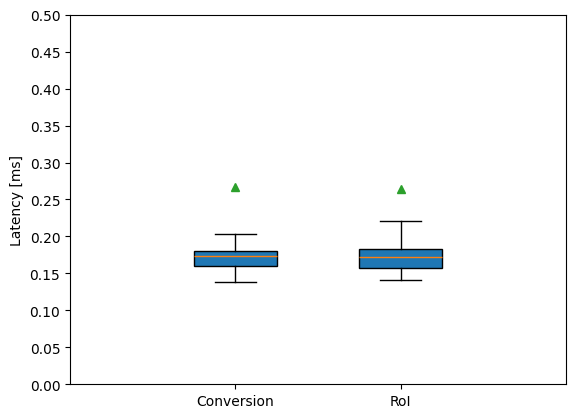

Mean Latency [ms]
Conversion 	 0.2667936893203883
RoI 		 0.264827519379845


In [21]:
# computation time: conversion vs. RoI
fig, ax = plt.subplots()
ax.boxplot(df_conversion['latency [ms]'].to_numpy(), positions=[2], widths=[1],
            patch_artist=True, showmeans=True, showfliers=False, tick_labels=['Conversion'])
ax.boxplot(df_roi['latency [ms]'].to_numpy(), positions=[4], widths=[1],
            patch_artist=True, showmeans=True, showfliers=False, tick_labels=['RoI'])
ax.set(xlim=(0, 6))
ax.set(ylim=(0, 0.5), yticks=[i/20 for i in range(11)], ylabel='Latency [ms]')
plt.show()
print('Mean Latency [ms]')
print('Conversion \t', df_conversion.mean()['latency [ms]'])
print('RoI \t\t', df_roi.mean()['latency [ms]'])
fig.savefig(os.path.join(FIG_DIR, 'conv_roi.png'))

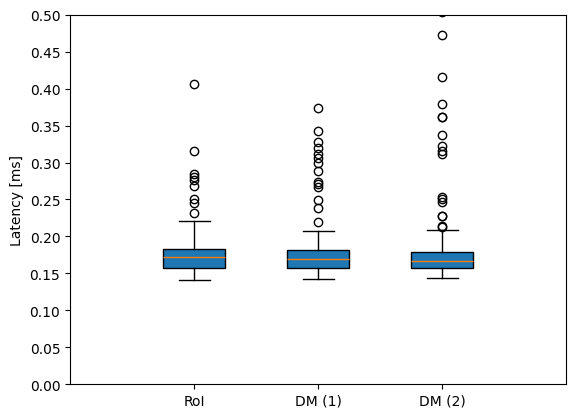

Mean Latency [ms]
RoI 		 0.264827519379845
DM (1) 		 0.2655542635658915
DM (2) 		 0.2655988372093023


In [24]:
# computation time: RoI vs. DM (1) vs. DM (2)
fig, ax = plt.subplots()
ax.boxplot(df_roi['latency [ms]'].to_numpy(), positions=[2], widths=[1],
            patch_artist=True, showmeans=False, showfliers=True, tick_labels=['RoI'])
ax.boxplot(df_dm1['latency [ms]'].to_numpy(), positions=[4], widths=[1],
            patch_artist=True, showmeans=False, showfliers=True, tick_labels=['DM (1)'])
ax.boxplot(df_dm2['latency [ms]'].to_numpy(), positions=[6], widths=[1],
            patch_artist=True, showmeans=False, showfliers=True, tick_labels=['DM (2)'])
ax.set(xlim=(0, 8))
ax.set(ylim=(0, 0.3), yticks=[i/20 for i in range(11)], ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(FIG_DIR, 'roi_dm.png'))

print('Mean Latency [ms]')
print('RoI \t\t', df_roi.mean()['latency [ms]'])
print('DM (1) \t\t', df_dm1.mean()['latency [ms]'])
print('DM (2) \t\t', df_dm2.mean()['latency [ms]'])

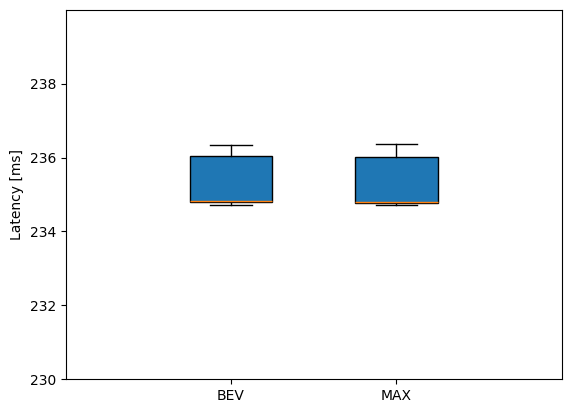

Mean Latency [ms]
BEV 		 211.70197142857143
MAX 		 211.6989295238095


In [37]:
# computation time: BEV vs. MAX
fig, ax = plt.subplots()
ax.boxplot(df_bev['latency [ms]'].to_numpy(), positions=[2], widths=[1],
            patch_artist=True, showmeans=False, showfliers=False, tick_labels=['BEV'])
ax.boxplot(df_max['latency [ms]'].to_numpy(), positions=[4], widths=[1],
            patch_artist=True, showmeans=False, showfliers=False, tick_labels=['MAX'])
ax.set(xlim=(0, 6))
ax.set(ylim=(230, 240), yticks=[230 + i * 2 for i in range(5)], ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(FIG_DIR, 'bev_max.png'))

print('Mean Latency [ms]')
print('BEV \t\t', df_bev.mean()['latency [ms]'])
print('MAX \t\t', df_max.mean()['latency [ms]'])